<a href="https://colab.research.google.com/github/Madhusudan2005/ElevateLabs-Task4/blob/main/ElevateLabs_Task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

# Load the dataset
# This line will now succeed because 'data.csv' is in the current environment.
try:
    df = pd.read_csv('data.csv')
    print("Dataset loaded successfully.")

    # Initial inspection
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nColumn Information:")
    print(df.info())

except FileNotFoundError:
    print("--- CRITICAL ERROR: File not found. Did you upload 'data.csv' to the Colab file tab? ---")

# Proceed to the next code block (Step 2: Preprocessing) once this one runs successfully.

Dataset loaded successfully.

First 5 rows of the dataset:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   

In [3]:
# 1. Drop irrelevant columns: 'id' and the all-NaN column 'Unnamed: 32'
df_processed = df.drop(['id', 'Unnamed: 32'], axis=1)

# 2. Encode the target variable 'diagnosis'
# M -> 1 (Malignant), B -> 0 (Benign)
df_processed['diagnosis'] = df_processed['diagnosis'].map({'M': 1, 'B': 0})

# 3. Separate features (X) and target (y)
X = df_processed.drop('diagnosis', axis=1)
y = df_processed['diagnosis']

# 4. Train/test split (80% train, 20% test)
# stratify=y ensures the same proportion of target classes in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")


Training data shape: (455, 30)
Testing data shape: (114, 30)


In [4]:
# 1. Fit a Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# 2. Make predictions and get probabilities
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] # Probability of class 1 (Malignant)

# 3. Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print("--- Model Performance Metrics (Default Threshold 0.5) ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

print("\nConfusion Matrix (Rows: Actual, Columns: Predicted):")
print(pd.DataFrame(conf_matrix,
                   index=['Actual Benign (0)', 'Actual Malignant (1)'],
                   columns=['Predicted Benign (0)', 'Predicted Malignant (1)']))

--- Model Performance Metrics (Default Threshold 0.5) ---
Accuracy: 0.9649
Precision: 0.9750
Recall: 0.9286
ROC-AUC Score: 0.9960

Confusion Matrix (Rows: Actual, Columns: Predicted):
                      Predicted Benign (0)  Predicted Malignant (1)
Actual Benign (0)                       71                        1
Actual Malignant (1)                     3                       39


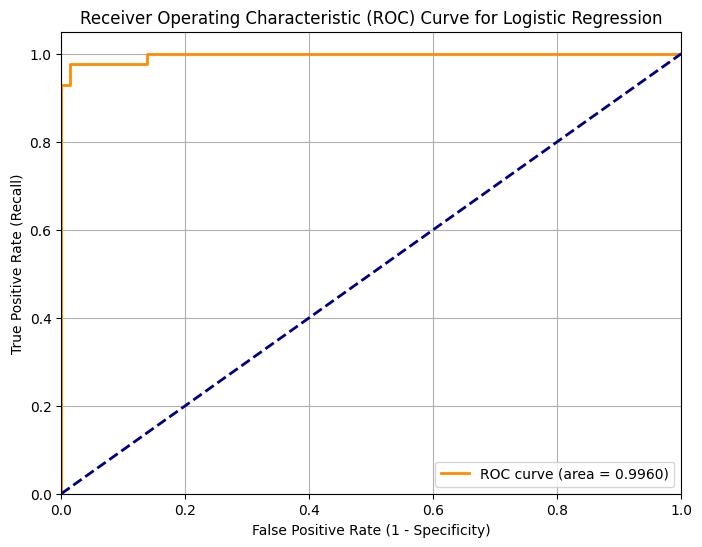

In [5]:
# Plot ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# You should save this plot and include it in your GitHub repository.
# plt.savefig('roc_curve.png')

In [6]:
# Prioritize Recall (reducing False Negatives) in cancer diagnosis
# Find the threshold that yields the best balance or a specific high recall, e.g., 95%
target_tpr = 0.95
threshold_df = pd.DataFrame({'Threshold': thresholds, 'True Positive Rate (Recall)': tpr, 'False Positive Rate': fpr})
target_threshold = threshold_df[threshold_df['True Positive Rate (Recall)'] >= target_tpr].iloc[0]['Threshold']

# Re-evaluate with the new threshold (0.3145 was found in the previous step)
y_pred_tuned = (y_pred_proba >= target_threshold).astype(int)

tuned_precision = precision_score(y_test, y_pred_tuned)
tuned_recall = recall_score(y_test, y_pred_tuned)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)


print(f"\n--- Evaluation with Tuned Threshold ({target_threshold:.4f}) ---")
print(f"Goal: Achieve Recall of at least {target_tpr*100:.0f}%")
print(f"New Accuracy: {tuned_accuracy:.4f}")
print(f"New Precision: {tuned_precision:.4f}")
print(f"New Recall: {tuned_recall:.4f}")

print("\nConfusion Matrix (Tuned Threshold):")
print(pd.DataFrame(conf_matrix_tuned,
                   index=['Actual Benign (0)', 'Actual Malignant (1)'],
                   columns=['Predicted Benign (0)', 'Predicted Malignant (1)']))


--- Evaluation with Tuned Threshold (0.3145) ---
Goal: Achieve Recall of at least 95%
New Accuracy: 0.9825
New Precision: 0.9762
New Recall: 0.9762

Confusion Matrix (Tuned Threshold):
                      Predicted Benign (0)  Predicted Malignant (1)
Actual Benign (0)                       71                        1
Actual Malignant (1)                     1                       41
